In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skhep.visual import MplPlotter as skh_plt
import os
import tdrstyle as tdr

ROOT.gStyle.SetOptStat(0)
tdr.setTDRStyle()

Welcome to JupyROOT 6.16/00


In [96]:
def Energy_loss(jet_pt, L):
    random = ROOT.TRandom3()
    
    # C = 0.055 # function3
    C = 0.0055
    dE_avg = C*pow(jet_pt,1)*pow(L,2)
    
    # C1 = 1.
    # C2 = 0.2
    # N = random.Exp(L/14.)

    # dE_avg = C1*pow(jet_pt,1)*pow(L,1) + (int(N)+1)*C2*pow(jet_pt,1)
    dE = random.PoissonD(dE_avg)
    
    return dE

In [3]:
def deltaPhi(phi1, phi2):
    dPhi = phi1 - phi2
    if dPhi > ROOT.TMath.Pi():
        dPhi -= 2.*ROOT.TMath.Pi()
    if dPhi < -ROOT.TMath.Pi():
        dPhi += 2.*ROOT.TMath.Pi()

    return dPhi


def deltaR(eta1, phi1, eta2, phi2):
    dEta = eta1 - eta2
    dPhi = deltaPhi(phi1, phi2)
    return ROOT.TMath.Sqrt(dEta*dEta+dPhi*dPhi)


def deltaEta(eta1, eta2):
    return eta1 - eta2

In [4]:
f_hM = ROOT.TFile('../GlauberMC/plots/histogram-R1R2.root','READ')
f_hM.cd()
hM_R1R2 = f_hM.Get('hM_R1R2')
hM_R1R2.SetDirectory(0)
f_hM.Close()

In [97]:
f = ROOT.TFile('./data/dijet_events_v2.root','READ')
tree = ROOT.gROOT.FindObject("EventTree")

list_pt_bin = [100,126,158,200]
list_hM_xJ = []
list_hM_xJ_dE = []
list_hM_AJ = []
list_hM_AJ_dE = []

ATLAS_bin = np.array([0.0,0.04,0.08,0.11,0.14,0.17,0.2,0.23,0.26,0.29,
             0.33597-0.01842,
             0.3769-0.02204,
             0.4231-0.02435,
             0.47459-0.02757,
             0.53267-0.03079,
             0.59736-0.03404,
             0.66997-0.03643,
             0.75182-0.04148,
             0.8429-0.04698,
             0.94587-0.05339,1.0], dtype='float64')

for ibin in range(len(list_pt_bin)):
    list_hM_xJ.append(ROOT.TH1F('hM_xJ','hM_xJ',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_xJ_dE.append(ROOT.TH1F('hM_xJ_dE','hM_xJ_dE',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_AJ.append(ROOT.TH1F('hM_AJ','hM_AJ',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_AJ_dE.append(ROOT.TH1F('hM_AJ_dE','hM_AJ_dE',len(ATLAS_bin)-1, ATLAS_bin))

    
hM_jetpt = ROOT.TH2F('hM_jetpt','hM_jetpt',100,0,500,100,0,500)
hM_dPhi = ROOT.TH1F('hM_dPhi','hM_dPhi',50,0,ROOT.TMath.Pi())

nEntries =  tree.GetEntries()
for iEntry in range(0,nEntries):
    tree.GetEntry(iEntry)
    
    if len(tree.pT) < 2:
        continue
        
    pT_jet1 = -1.
    pT_jet2 = -1.
    if tree.pT[0] > tree.pT[1]:
        pT_jet1 = tree.pT[0]
        pT_jet2 = tree.pT[1]
    else:
        pT_jet1 = tree.pT[1]
        pT_jet2 = tree.pT[0]
    
    
    hM_jetpt.Fill(tree.pT[0],tree.pT[1])
    hM_dPhi.Fill(abs(deltaPhi(tree.phi[0],tree.phi[1])))
    
    # Jet selection, following ATLAS analysis arXiv:1706.09363
    if pT_jet1 < 25. or pT_jet2 < 25.:
        continue
        
    if abs(tree.eta[0]) > 2.1 or abs(tree.eta[1]) > 2.1:
        continue
        
    if abs(deltaPhi(tree.phi[0],tree.phi[1])) < (7.*ROOT.TMath.Pi())/8.:
        continue
    
    if pT_jet1 < 100.:
        continue
        
    
    xJ = pT_jet2/pT_jet1
    AJ = (pT_jet1-pT_jet2)/(pT_jet1+pT_jet2)
    
    L1 = ROOT.Double(0.0)
    L2 = ROOT.Double(0.0)
    hM_R1R2.GetRandom2(L1,L2)
    
    dE_jet1 = Energy_loss(pT_jet1, L1)
    dE_jet2 = Energy_loss(pT_jet2, L2)
    
    pT_jet1_dE = pT_jet1 - dE_jet1
    pT_jet2_dE = pT_jet2 - dE_jet2
    if pT_jet1_dE < pT_jet2_dE:
        tmp = pT_jet2_dE
        pT_jet2_dE = pT_jet1_dE
        pT_jet1_dE = tmp
    
    xJ_dE = pT_jet2_dE/pT_jet1_dE
    AJ_dE = (pT_jet1_dE-pT_jet2_dE)/(pT_jet1_dE+pT_jet2_dE)
    
    if iEntry < 10:
        print (xJ,xJ_dE)
        
    if pT_jet1 > 100. and pT_jet1 < 126.:
        list_hM_xJ[0].Fill(xJ)
        list_hM_xJ_dE[0].Fill(xJ_dE)
        list_hM_AJ[0].Fill(AJ)
        list_hM_AJ_dE[0].Fill(AJ_dE)
    elif pT_jet1 > 126. and pT_jet1 < 158.:
        list_hM_xJ[1].Fill(xJ)
        list_hM_xJ_dE[1].Fill(xJ_dE)
        list_hM_AJ[1].Fill(AJ)
        list_hM_AJ_dE[1].Fill(AJ_dE)
    elif pT_jet1 > 158. and pT_jet1 < 200.:
        list_hM_xJ[2].Fill(xJ)
        list_hM_xJ_dE[2].Fill(xJ_dE)
        list_hM_AJ[2].Fill(AJ)
        list_hM_AJ_dE[2].Fill(AJ_dE)
    elif pT_jet1 > 200.:
        list_hM_xJ[3].Fill(xJ)
        list_hM_xJ_dE[3].Fill(xJ_dE)
        list_hM_AJ[3].Fill(AJ)
        list_hM_AJ_dE[3].Fill(AJ_dE)
    else:
        continue

Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0
Info in <TCanvas::Print>: png file ./plots/JetpT-distribution-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/JetpT-distribution-v2.pdf has been created


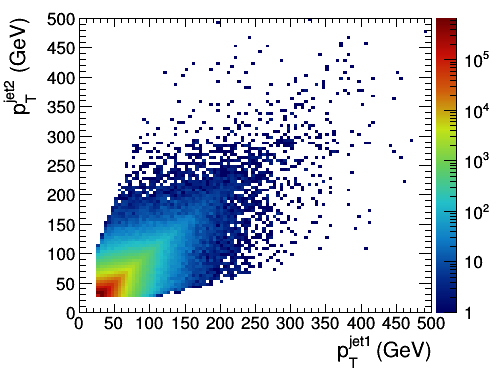

In [91]:
c0 = ROOT.TCanvas('c0', 'c0', 500, 400)
ROOT.gStyle.SetPalette(55)
c0.cd()
# c0.SetLogx()
# c0.SetLogy()
c0.SetLogz()
ROOT.gPad.SetRightMargin(0.13)
ROOT.gPad.SetBottomMargin(0.16)
hM_jetpt.GetXaxis().SetTitle('p_{T}^{jet1} (GeV)')
hM_jetpt.GetYaxis().SetTitle('p_{T}^{jet2} (GeV)')
hM_jetpt.GetXaxis().SetTitleOffset(1.1)
hM_jetpt.SetContour(2000)
hM_jetpt.Draw('colz')

ROOT.gPad.Update()
palette = hM_jetpt.GetListOfFunctions().FindObject('palette')
palette.SetX1NDC(0.88)
palette.SetX2NDC(0.92)
palette.SetY1NDC(0.16)
palette.SetY2NDC(0.95)
ROOT.gPad.Modified()
ROOT.gPad.Update()

c0.Draw()
c0.SaveAs('./plots/JetpT-distribution-v2.png')
c0.SaveAs('./plots/JetpT-distribution-v2.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file ./plots/DijetDeltaPhi-distribution-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/DijetDeltaPhi-distribution-v2.pdf has been created


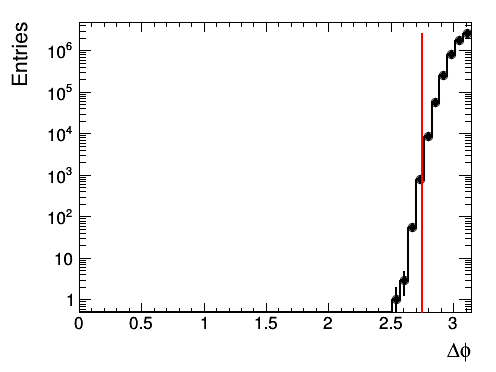

In [89]:
c1 = ROOT.TCanvas('c1', 'c1', 500, 400)
c1.cd()
c1.SetLogy()
ROOT.gPad.SetRightMargin(0.05)
ROOT.gPad.SetBottomMargin(0.16)
ROOT.gPad.SetTopMargin(0.06)
hM_dPhi.GetXaxis().SetTitle('#Delta#phi')
hM_dPhi.GetYaxis().SetTitle('Entries')
hM_dPhi.GetXaxis().SetTitleOffset(1.1)
hM_dPhi.SetLineWidth(2)
hM_dPhi.Draw('histe')

l = ROOT.TLine(7.*ROOT.TMath.Pi()/8.,c1.GetUymin(),7.*ROOT.TMath.Pi()/8.,hM_dPhi.GetMaximum())
l.SetLineColor(2)
l.SetLineWidth(2)
l.Draw('same')

c1.Draw()
c1.SaveAs('./plots/DijetDeltaPhi-distribution-v2.png')
c1.SaveAs('./plots/DijetDeltaPhi-distribution-v2.pdf')

In [8]:
### ATLAS results from https://arxiv.org/abs/1706.09363

ATLAS_PbPb_Xbin = [0.33597,0.3769,0.4231,0.47459,0.53267,0.59736,0.66997,0.75182,0.8429,0.94587]
ATLAS_PbPb_Xup = [0.01889,0.02185,0.02392,0.02729,0.03065,0.03399,0.03818,0.04410,0.04958,0.05413]
ATLAS_PbPb_Xdown = [0.01842,0.02204,0.02435,0.02757,0.03079,0.03404,0.03643,0.04148,0.04698,0.05339]

ATLAS_PbPb_100to126_central = [0.0536,0.27471,0.79062,1.75544,2.51256,2.34506,1.76884,1.42044,1.37353,1.34673]
ATLAS_PbPb_100to126_Statup = [0.0335,0.02680,0.04020,0.04691,0.04020,0.04020,0.04021,0.04020,0.03351,0.03350]
ATLAS_PbPb_100to126_Statdown = [0.0469,0.04020,0.04690,0.05360,0.04690,0.04020,0.04020,0.04021,0.04020,0.04020]
ATLAS_PbPb_100to126_Systup = [0.0603,0.20100,0.34841,0.45562,0.40201,0.25460,0.18091,0.14740,0.14741,0.14741]
ATLAS_PbPb_100to126_Systdown = [0.0536,0.20771,0.34841,0.46231,0.40871,0.25461,0.18090,0.15411,0.15410,0.16080]
Norm_PbPb_100to126 = 0.0
for ibin in range(len(ATLAS_PbPb_100to126_central)):
    Norm_PbPb_100to126 = Norm_PbPb_100to126 + ATLAS_PbPb_100to126_central[ibin]


ATLAS_PbPb_126to158_central = [0.1745,0.73826,1.26174,1.5302,1.66443,1.65101,1.65101,1.61074,1.65101,1.58389]
ATLAS_PbPb_126to158_Statup = [0.05369,0.08053,0.06712,0.06712,0.08054,0.05369,0.05369,0.05369,0.05369,0.05369]
ATLAS_PbPb_126to158_Statdown = [0.04027,0.06712,0.08053,0.06711,0.06711,0.05369,0.05369,0.05369,0.05369,0.05369]
ATLAS_PbPb_126to158_Systup = [0.10738,0.34899,0.46980,0.52349,0.33557,0.21476,0.16107,0.12080,0.09396,0.05369]
ATLAS_PbPb_126to158_Systdown = [0.10739,0.33558,0.48322,0.52349,0.32215,0.21477,0.16108,0.12081,0.08054,0.06711]
Norm_PbPb_126to158 = 0.0
for ibin in range(len(ATLAS_PbPb_126to158_central)):
    Norm_PbPb_126to158 = Norm_PbPb_126to158 + ATLAS_PbPb_126to158_central[ibin]



ATLAS_PbPb_158to200_central = [0.63545,0.47492,1.26421,1.55853,1.43813,1.43813,1.67893,1.77258,1.67893,1.62542]
ATLAS_PbPb_158to200_Statup = [0.17391,0.09364,0.13378,0.13378,0.10702,0.09364,0.10702,0.10702,0.06689,0.09364]
ATLAS_PbPb_158to200_Statdown = [0.17391,0.09365,0.14715,0.13378,0.10703,0.08027,0.10702,0.09365,0.06689,0.10703]
ATLAS_PbPb_158to200_Systup = [0.64214,0.60200,0.58863,0.53512,0.28093,0.17391,0.16053,0.13377,0.12040,0.10702]
ATLAS_PbPb_158to200_Systdown = [0.62876,0.46823,0.60200,0.52174,0.28094,0.16054,0.14716,0.13378,0.12040,0.12040]
Norm_PbPb_158to200 = 0.0
for ibin in range(len(ATLAS_PbPb_158to200_central)):
    Norm_PbPb_158to200 = Norm_PbPb_158to200 + ATLAS_PbPb_158to200_central[ibin]


ATLAS_PbPb_200toinv_central = [0.31438,0.46154,0.91639,1.17057,1.11706,1.26421,1.47826,1.69231,1.90635,2.38796]
ATLAS_PbPb_200toinv_Statup = [0.12040,0.12040,0.13378,0.16053,0.13378,0.13378,0.13378,0.16053,0.12041,0.17391]
ATLAS_PbPb_200toinv_Statdown = [0.12040,0.10702,0.13378,0.17391,0.13378,0.13378,0.12040,0.13378,0.13377,0.16054]
ATLAS_PbPb_200toinv_Systup = [0.32107,0.41471,0.36120,0.32107,0.22742,0.18730,0.18729,0.18729,0.16054,0.17391]
ATLAS_PbPb_200toinv_Systdown = [0.30769,0.42810,0.36121,0.33445,0.22743,0.17391,0.20067,0.18729,0.17391,0.17391]
Norm_PbPb_200toinv = 0.0
for ibin in range(len(ATLAS_PbPb_200toinv_central)):
    Norm_PbPb_200toinv = Norm_PbPb_200toinv + ATLAS_PbPb_200toinv_central[ibin]

Nbins_ATLAS = 10

gr_ATLAS_PbPb_100to126_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_100to126_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_100to126_Statdown),
                                                np.array(ATLAS_PbPb_100to126_Statup))

gr_ATLAS_PbPb_100to126_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_100to126_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_100to126_Systdown),
                                                np.array(ATLAS_PbPb_100to126_Systup))

gr_ATLAS_PbPb_126to158_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_126to158_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_126to158_Statdown),
                                                np.array(ATLAS_PbPb_126to158_Statup))

gr_ATLAS_PbPb_126to158_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_126to158_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_126to158_Systdown),
                                                np.array(ATLAS_PbPb_126to158_Systup))

gr_ATLAS_PbPb_158to200_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_158to200_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_158to200_Statdown),
                                                np.array(ATLAS_PbPb_158to200_Statup))

gr_ATLAS_PbPb_158to200_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_158to200_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_158to200_Systdown),
                                                np.array(ATLAS_PbPb_158to200_Systup))

gr_ATLAS_PbPb_200toinv_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_200toinv_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_200toinv_Statdown),
                                                np.array(ATLAS_PbPb_200toinv_Statup))

gr_ATLAS_PbPb_200toinv_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_PbPb_200toinv_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_PbPb_200toinv_Systdown),
                                                np.array(ATLAS_PbPb_200toinv_Systup))


list_ATLAS_Norm_PbPb = []
list_ATLAS_Norm_PbPb.append(Norm_PbPb_100to126)
list_ATLAS_Norm_PbPb.append(Norm_PbPb_126to158)
list_ATLAS_Norm_PbPb.append(Norm_PbPb_158to200)
list_ATLAS_Norm_PbPb.append(Norm_PbPb_200toinv)

list_ATLAS_gr_Stat = []
list_ATLAS_gr_Stat.append(gr_ATLAS_PbPb_100to126_Stat)
list_ATLAS_gr_Stat.append(gr_ATLAS_PbPb_126to158_Stat)
list_ATLAS_gr_Stat.append(gr_ATLAS_PbPb_158to200_Stat)
list_ATLAS_gr_Stat.append(gr_ATLAS_PbPb_200toinv_Stat)

list_ATLAS_gr_Syst = []
list_ATLAS_gr_Syst.append(gr_ATLAS_PbPb_100to126_Syst)
list_ATLAS_gr_Syst.append(gr_ATLAS_PbPb_126to158_Syst)
list_ATLAS_gr_Syst.append(gr_ATLAS_PbPb_158to200_Syst)
list_ATLAS_gr_Syst.append(gr_ATLAS_PbPb_200toinv_Syst)

In [29]:
### ATLAS results from https://arxiv.org/abs/1706.09363

ATLAS_pp_100to126_central = [0.1541,0.32161,0.56281,0.85762,1.11893,1.31323,1.48074,1.72194,2.17755,2.51256]
ATLAS_pp_100to126_Statup = [0.06031,0.05360,0.06031,0.05360,0.05360,0.05360,0.06030,0.06030,0.05361,0.09381]
ATLAS_pp_100to126_Statdown = [0.0603,0.05360,0.06030,0.06030,0.06030,0.06030,0.06030,0.05360,0.06030,0.08710]
ATLAS_pp_100to126_Systup = [0.0402,0.06030,0.06701,0.06030,0.04690,0.04690,0.05360,0.05360,0.04021,0.03350]
ATLAS_pp_100to126_Systdown = [0.0402,0.06030,0.06030,0.06700,0.05360,0.05360,0.05360,0.04690,0.04690,0.03350]
Norm_pp_100to126 = 0.0
for ibin in range(len(ATLAS_pp_100to126_central)):
    Norm_pp_100to126 = Norm_pp_100to126 + ATLAS_pp_100to126_central[ibin]


ATLAS_pp_126to158_central = [0.10406,0.25462,0.48034,0.79371,1.04455,1.23288,1.42127,1.72239,2.26142,2.72544]
ATLAS_pp_126to158_Statup = [0.07510,0.06259,0.06258,0.06258,0.06258,0.06258,0.06258,0.06258,0.0625799999999996,0.12517]
ATLAS_pp_126to158_Statdown = [0.07508,0.07510,0.06260,0.07510,0.07510,0.07510,0.07510,0.07510,0.07510,0.13768]
ATLAS_pp_126to158_Systup = [0.02503,0.01252,0.03755,0.03755,0.05006,0.03753,0.05006,0.03755,0.03755,0.02503]
ATLAS_pp_126to158_Systdown = [0.02503,0.02503,0.02503,0.05007,0.05007,0.0500799999999999,0.0500700000000001,0.05006,0.05007,0.02503]
Norm_pp_126to158 = 0.0
for ibin in range(len(ATLAS_pp_126to158_central)):
    Norm_pp_126to158 = Norm_pp_126to158 + ATLAS_pp_126to158_central[ibin]



ATLAS_pp_158to200_central = [0.08399,0.20933,0.4097,0.71008,0.98552,1.14857,1.31167,1.62482,2.30047,2.97622]
ATLAS_pp_158to200_Statup = [0.06249,0.06248,0.06248,0.06248,0.07498,0.06248,0.06248,0.07498,0.07498,0.0874799999999998]
ATLAS_pp_158to200_Statdown = [0.06248,0.08748,0.07498,0.08748,0.06248,0.07498,0.07498,0.08748,0.07498,0.09998]
ATLAS_pp_158to200_Systup = [0.02501,0.03747,0.03747,0.04999,0.03749,0.02499,0.02501,0.03749,0.03749,0.02499]
ATLAS_pp_158to200_Systdown = [0.01249,0.03749,0.03749,0.04999,0.02499,0.02500,0.03749,0.03749,0.04998,0.04999]
Norm_pp_158to200 = 0.0
for ibin in range(len(ATLAS_pp_158to200_central)):
    Norm_pp_158to200 = Norm_pp_158to200 + ATLAS_pp_158to200_central[ibin]


ATLAS_pp_200toinv_central = [0.0789,0.19174,0.34212,0.55503,0.83047,1.08099,1.30657,1.58224,2.27038,3.33353]
ATLAS_pp_200toinv_Statup = [0.07499,0.07498,0.07498,0.06248,0.06248,0.06249,0.06251,0.06248,0.07499,0.09998]
ATLAS_pp_200toinv_Statdown = [0.06248,0.07498,0.06248,0.07498,0.08748,0.07498,0.07498,0.07499,0.07498,0.08748]
ATLAS_pp_200toinv_Systup = [0.0125,0.02501,0.03749,0.03747,0.03747,0.0500100000000001,0.04999,0.04998,0.06249,0.06248]
ATLAS_pp_200toinv_Systdown = [0.01249,0.02499,0.03749,0.03751,0.04999,0.04999,0.04998,0.06249,0.0499799999999997,0.04999]
Norm_pp_200toinv = 0.0
for ibin in range(len(ATLAS_pp_200toinv_central)):
    Norm_pp_200toinv = Norm_pp_200toinv + ATLAS_pp_200toinv_central[ibin]

Nbins_ATLAS = 10

gr_ATLAS_pp_100to126_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_100to126_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_100to126_Statdown),
                                                np.array(ATLAS_pp_100to126_Statup))

gr_ATLAS_pp_100to126_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_100to126_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_100to126_Systdown),
                                                np.array(ATLAS_pp_100to126_Systup))

gr_ATLAS_pp_126to158_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_126to158_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_126to158_Statdown),
                                                np.array(ATLAS_pp_126to158_Statup))

gr_ATLAS_pp_126to158_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_126to158_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_126to158_Systdown),
                                                np.array(ATLAS_pp_126to158_Systup))

gr_ATLAS_pp_158to200_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_158to200_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_158to200_Statdown),
                                                np.array(ATLAS_pp_158to200_Statup))

gr_ATLAS_pp_158to200_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_158to200_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_158to200_Systdown),
                                                np.array(ATLAS_pp_158to200_Systup))

gr_ATLAS_pp_200toinv_Stat = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_200toinv_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_200toinv_Statdown),
                                                np.array(ATLAS_pp_200toinv_Statup))

gr_ATLAS_pp_200toinv_Syst = ROOT.TGraphAsymmErrors(Nbins_ATLAS,
                                                np.array(ATLAS_PbPb_Xbin),
                                                np.array(ATLAS_pp_200toinv_central),
                                                np.array(ATLAS_PbPb_Xdown),
                                                np.array(ATLAS_PbPb_Xup),
                                                np.array(ATLAS_pp_200toinv_Systdown),
                                                np.array(ATLAS_pp_200toinv_Systup))


list_ATLAS_Norm_pp = []
list_ATLAS_Norm_pp.append(Norm_pp_100to126)
list_ATLAS_Norm_pp.append(Norm_pp_126to158)
list_ATLAS_Norm_pp.append(Norm_pp_158to200)
list_ATLAS_Norm_pp.append(Norm_pp_200toinv)

list_ATLAS_gr_pp_Stat = []
list_ATLAS_gr_pp_Stat.append(gr_ATLAS_pp_100to126_Stat)
list_ATLAS_gr_pp_Stat.append(gr_ATLAS_pp_126to158_Stat)
list_ATLAS_gr_pp_Stat.append(gr_ATLAS_pp_158to200_Stat)
list_ATLAS_gr_pp_Stat.append(gr_ATLAS_pp_200toinv_Stat)

list_ATLAS_gr_pp_Syst = []
list_ATLAS_gr_pp_Syst.append(gr_ATLAS_pp_100to126_Syst)
list_ATLAS_gr_pp_Syst.append(gr_ATLAS_pp_126to158_Syst)
list_ATLAS_gr_pp_Syst.append(gr_ATLAS_pp_158to200_Syst)
list_ATLAS_gr_pp_Syst.append(gr_ATLAS_pp_200toinv_Syst)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./plots/xJ-inclusive-pp-EnergyLoss-function2-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/xJ-inclusive-pp-EnergyLoss-function2-v2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cl
Info in <TCanvas::Print>: png file ./plots/legend-xJ-inclusive-pp-EnergyLoss.png has been created
Info in <TCanvas::Print>: pdf file ./plots/legend-xJ-inclusive-pp-EnergyLoss.pdf has been created


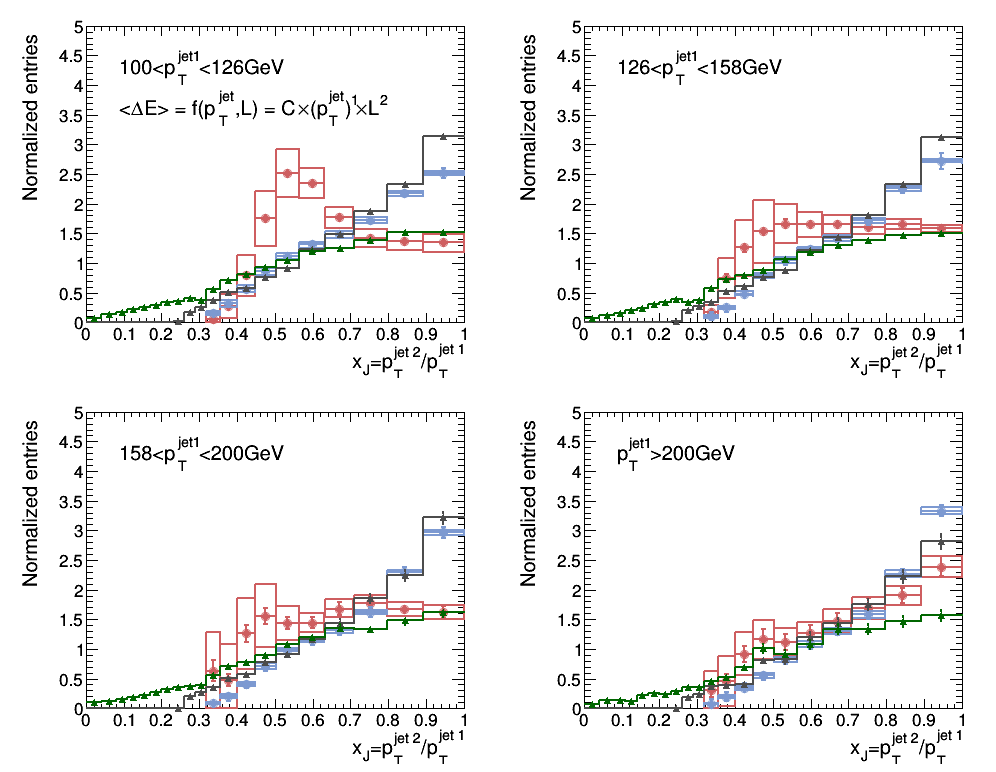

In [98]:
for ibin in range(len(list_pt_bin)):
    list_hM_xJ[ibin].Scale(list_ATLAS_Norm_PbPb[ibin]/list_hM_xJ[ibin].Integral(-1,-1))
    list_hM_xJ_dE[ibin].Scale(list_ATLAS_Norm_PbPb[ibin]/list_hM_xJ_dE[ibin].Integral(-1,-1))
    
    
list_extratext = ['100<p_{T}^{jet1}<126GeV','126<p_{T}^{jet1}<158GeV','158<p_{T}^{jet1}<200GeV','p_{T}^{jet1}>200GeV']

c = ROOT.TCanvas('c', 'c', 1000, 800)
c.Divide(2,2)

for icd in range(len(list_pt_bin)):
    c.cd(icd+1)
    ROOT.gPad.SetRightMargin(0.05)
    ROOT.gPad.SetBottomMargin(0.15)
    list_hM_xJ[icd].SetLineWidth(2)
    list_hM_xJ[icd].SetMarkerStyle(22)
    list_hM_xJ[icd].SetLineColor(12)
    list_hM_xJ[icd].SetMarkerColor(12)
    list_hM_xJ[icd].GetXaxis().SetTitle('x_{J}=p_{T}^{jet 2}/p_{T}^{jet 1}')
    list_hM_xJ[icd].GetYaxis().SetTitle('Normalized entries')
    list_hM_xJ[icd].GetXaxis().SetTitleOffset(1.1)
    list_hM_xJ[icd].GetYaxis().SetRangeUser(0,5)
    list_hM_xJ[icd].Draw('histeX0')

    list_hM_xJ_dE[icd].SetLineWidth(2)
    list_hM_xJ_dE[icd].SetMarkerStyle(22)
    list_hM_xJ_dE[icd].SetLineColor(ROOT.kGreen+3)
    list_hM_xJ_dE[icd].SetMarkerColor(ROOT.kGreen+3)
    list_hM_xJ_dE[icd].Draw('histeX0same')

#     list_ATLAS_gr_Syst[icd].GetXaxis().SetLimits(0,1)
#     list_ATLAS_gr_Syst[icd].GetYaxis().SetRangeUser(0,5)
    list_ATLAS_gr_Syst[icd].SetMarkerColor(46)
    list_ATLAS_gr_Syst[icd].SetFillColor(ROOT.kRed-9)
    list_ATLAS_gr_Syst[icd].SetLineColor(46)
    list_ATLAS_gr_Syst[icd].SetLineWidth(2)
    list_ATLAS_gr_Syst[icd].SetMarkerStyle(20)
    list_ATLAS_gr_Syst[icd].SetFillStyle(0)
    list_ATLAS_gr_Syst[icd].Draw('E2same')
    
    list_ATLAS_gr_Stat[icd].SetMarkerColor(46)
    list_ATLAS_gr_Stat[icd].SetLineColor(46)
    list_ATLAS_gr_Stat[icd].SetLineWidth(2)
    list_ATLAS_gr_Stat[icd].SetMarkerStyle(20)
    list_ATLAS_gr_Stat[icd].Draw('Psame')
    
    list_ATLAS_gr_pp_Syst[icd].SetMarkerColor(38)
    list_ATLAS_gr_pp_Syst[icd].SetFillColor(ROOT.kBlue-9)
    list_ATLAS_gr_pp_Syst[icd].SetLineColor(38)
    list_ATLAS_gr_pp_Syst[icd].SetLineWidth(2)
    list_ATLAS_gr_pp_Syst[icd].SetMarkerStyle(20)
    list_ATLAS_gr_pp_Syst[icd].SetFillStyle(0)
    list_ATLAS_gr_pp_Syst[icd].Draw('E2same')
    
    list_ATLAS_gr_pp_Stat[icd].SetMarkerColor(38)
    list_ATLAS_gr_pp_Stat[icd].SetLineColor(38)
    list_ATLAS_gr_pp_Stat[icd].SetLineWidth(2)
    list_ATLAS_gr_pp_Stat[icd].SetMarkerStyle(20)
    list_ATLAS_gr_pp_Stat[icd].Draw('Psame')
    
    list_hM_xJ[icd].Draw('histeX0same')
    list_hM_xJ_dE[icd].Draw('histeX0same')
    
    if icd == 0:
        latex = ROOT.TLatex()
        latex.SetNDC()
        latex.SetTextFont(42)
        latex.SetTextSize(0.06)
        latex.DrawLatex(0.23, 0.71, '<#DeltaE> = f(p_{T}^{jet},L) = C#times(p_{T}^{jet})^{1}#timesL^{2}')
        # latex.DrawLatex(0.28, 0.72, '<#DeltaE> = f(p_{T}^{jet},L) = C_{1}#times(p_{T}^{jet})^{1}#timesL^{1}+N#timesC_{2}#times(p_{T}^{jet})^{1}')
        # latex.DrawLatex(0.35, 0.7, '<#DeltaE> = collision loss + radiation loss')
        
    extratext = ROOT.TLatex()
    extratext.SetNDC()
    extratext.SetTextFont(42)
    extratext.SetTextSize(0.06)
    extratext.DrawLatex(0.23, 0.82, list_extratext[icd])
        

c.Draw()
c.SaveAs('./plots/xJ-inclusive-pp-EnergyLoss-function2-v2.png')
c.SaveAs('./plots/xJ-inclusive-pp-EnergyLoss-function2-v2.pdf')


cl = ROOT.TCanvas('cl', 'cl', 200, 200)
cl.cd()
legend = ROOT.TLegend(0.01,0.01,0.98,0.98)
legend.SetBorderSize(0);
legend.AddEntry(list_hM_xJ[icd],'pp events','leX0p')
legend.AddEntry(list_hM_xJ_dE[icd],'#splitline{pp events}{with energy loss}','leX0p')
legend.AddEntry(list_ATLAS_gr_pp_Syst[icd],'#splitline{ATLAS pp results}{(arXiv:1706.09363)}','lfp')
legend.AddEntry(list_ATLAS_gr_Syst[icd],'#splitline{ATLAS PbPb results}{(arXiv:1706.09363)}','lfp')
legend.Draw('same')
legend.Draw()
cl.SaveAs('./plots/legend-xJ-inclusive-pp-EnergyLoss.png')
cl.SaveAs('./plots/legend-xJ-inclusive-pp-EnergyLoss.pdf')